# ML model in pytorch:

## Setting up:
### Additional installations

In [1]:
! pip install cartopy
! pip install pyproj
! pip install wandb
! pip install -U -q PyDrive
! pip uninstall shapely
! pip install shapely --no-binary shapely

     |████████████████████████████████| 10.8 MB 7.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 47.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 42.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 48.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 3.8 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516313 sha256=a61dfa4d779c0895f5ee7591656d19bfc5ec86e48886aa7cb9211b3d4054caa3
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
Successfully built cartopy
     |███

### Imports:

In [2]:
# Basics
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import os
import sys
from pathlib import Path
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from re import search
from math import cos,sin,pi
import random as rn
from google.colab import auth
from google.colab import files

# xarray and cartopy plots
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import pyproj
from pyproj import Transformer

# ML
from scipy import ndimage
import torch
import tensorflow as tf 
import torch.nn as nn
import torch.nn.functional as F
import argparse
import logging
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split
#import setGPU

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up CUDA:

In [3]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
if torch.cuda.is_available():
  cuda_id = torch.cuda.current_device()
  print(f"ID of current CUDA device:{torch.cuda.current_device()}")
          
  print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? True
CUDA version: 11.3
ID of current CUDA device:0
Name of current CUDA device:Tesla P100-PCIE-16GB


### Helper scripts:

In [4]:
# Load configuration file:
from config import *
from dataFunctions import *
from makeInputs import *
from metrics import *
# Import custom scripts
#sys.path.append('../')
#from GC_scripts import * # Google cloud scripts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up Google Cloud:

In [5]:
"""
auth.authenticate_user()
# Give our project ID
project_id = 'ee-iceshelf-gee4geo'
!gcloud config set project {project_id}
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://ee-downscalingclimatemodels/test.txt /tmp/gsutil_download.txt
# Print the result to make sure the transfer worked.
!cat /tmp/gsutil_download.txt"""

"\nauth.authenticate_user()\n# Give our project ID\nproject_id = 'ee-iceshelf-gee4geo'\n!gcloud config set project {project_id}\n# Download the file from a given Google Cloud Storage bucket.\n!gsutil cp gs://ee-downscalingclimatemodels/test.txt /tmp/gsutil_download.txt\n# Print the result to make sure the transfer worked.\n!cat /tmp/gsutil_download.txt"

### Set up Google Drive:

In [6]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
Googledrive = GoogleDrive(gauth)

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
!ls /content/gdrive/My\ Drive/Master-thesis/saved_models/

MODEL_2022-05-11_Larsen_100_32_Baseline.pth
MODEL_2022-05-16_Larsen_100_32_Baseline_MSE.pth
MODEL_2022-05-16_Larsen_100_32_Baseline_NRMSE.pth
MODEL_2022-05-16_Larsen_100_32_Baseline_RMSE.pth
MODEL_2022-05-17_Larsen_100_32_Attention_MSE.pth
MODEL_2022-05-17_Larsen_100_32_Attention_NRMSE.pth
MODEL_2022-05-17_Larsen_100_32_Attention_RMSE.pth
MODEL_2022-05-19_Larsen_100_32_Attention_NRMSE.pth


## Load data:

### (Input) Global climate model:

In [9]:
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileGCMLike)
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)
else:
    linkGCMLike = 'https://drive.google.com/file/d/1AVOnOqvV9YPiJTPoPWHWu3uk7293dqAo/view?usp=sharing'
    idGCMLike = '1AVOnOqvV9YPiJTPoPWHWu3uk7293dqAo'
    downloaded = Googledrive.CreateFile({'id':idGCMLike}) 
    downloaded.GetContentFile(fileGCMLike)  
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)
print(GCMLike.dims)
GCMLike

Frozen({'x': 90, 'y': 25, 'time': 1452})


<xarray.Dataset>
Dimensions:      (x: 90, y: 25, time: 1452)
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
Data variables:
    RF           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    SMB          (time, y, x) float32 ...
    VVP          (time, y, x) float64 ...
    UUP          (time, y, x) float64 ...
Attributes:
    crs:      3031

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarnin

/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:556: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be rem

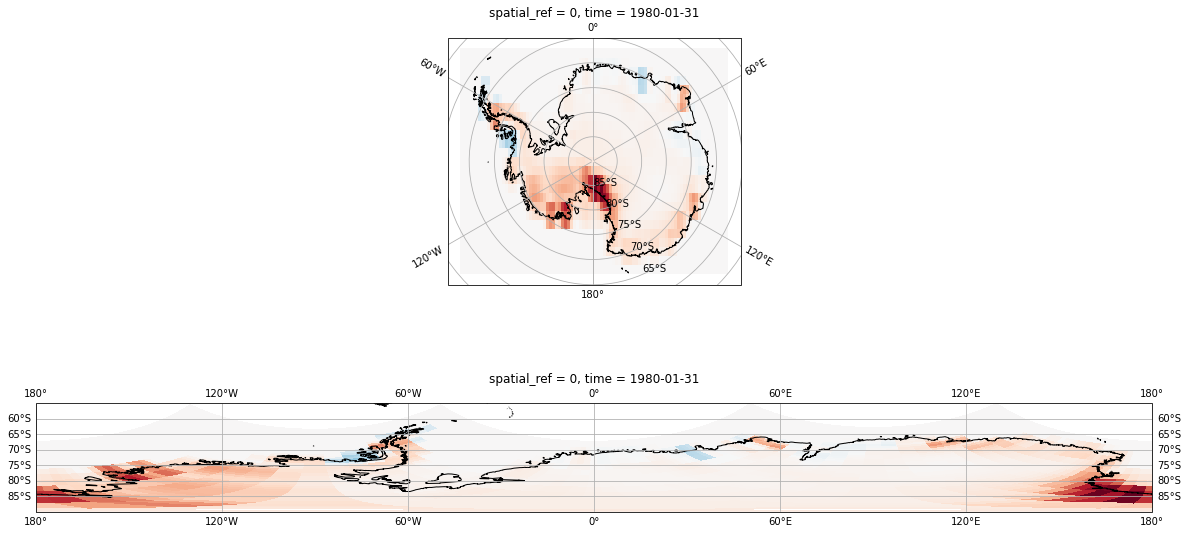

In [10]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(2, 1, 1, projection=ccrs.SouthPolarStereo())
GCMLike.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=False
)
ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

ax = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
GCMLike.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=False
)
ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

### (Target) Regional climate model:

In [11]:
%%time
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileTarget)
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
else:
    smoothed = True
    if smoothed:
      linkTarget = 'https://drive.google.com/file/d/15Kd81r9k6SA-1gTnpNZqBf4snl1UksbI/view?usp=sharing'
      idTarget = '15Kd81r9k6SA-1gTnpNZqBf4snl1UksbI'
      downloaded = Googledrive.CreateFile({'id':idTarget}) 
      downloaded.GetContentFile(fileTargetSmoothed) 
      target_dataset = xr.open_dataset(fileTargetSmoothed)
      os.remove(fileTargetSmoothed)
    else:
      linkTarget = 'https://drive.google.com/file/d/15Kd81r9k6SA-1gTnpNZqBf4snl1UksbI/view?usp=sharing'
      idTarget = '15Kd81r9k6SA-1gTnpNZqBf4snl1UksbI'
      downloaded = Googledrive.CreateFile({'id':idTarget}) 
      downloaded.GetContentFile(fileTarget) 
      target_dataset = xr.open_dataset(fileTarget)
      os.remove(fileTarget)
print(target_dataset.dims)

# Cut a small part of on the right that is not too important
N = 160
max_x = (N / 2) * 35 * 1000
max_y = (N / 2) * 35 * 1000

target_dataset = cutBoundaries(target_dataset, max_x, max_y)
print("New target dimensions:", target_dataset.dims)

Frozen({'time': 1452, 'y': 148, 'x': 176, 'PLEV': 7})
New target dimensions: Frozen({'time': 1452, 'y': 148, 'x': 160, 'PLEV': 7})
CPU times: user 27 s, sys: 5.78 s, total: 32.8 s
Wall time: 2min 25s


## Input and target for model:

**Z**:
- (ignore for now) External forcing also given to RCM → total concentration of greenhouse gases and solar and ozone forcings
- Cosinus, sinus vector to encode information about day of year
- Daily spatial means and standard deviations time series for each $X_{i,j,m}$ (because normalising 2D variables removes temporal information)

**X**: 
SHAPE `[nbmonths, x, y, nb_vars]`

For pytorch need to put into `[nbmonths, nb_vars, x, y]`

### Input:

In [12]:
if REGION == "Combined":
    inputs_2D = []
    inputs_1D = []
    inputs_2D_ns = []
    inputs_1D_ns = []
    i = 0
    for r in REGIONS:
        i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
            GCMLike, SIZE_INPUT_DOMAIN, Region=r, regionNbr=i
        )
        inputs_1D.append(i1D)
        inputs_2D.append(i2D)
        inputs_1D_ns.append(i1D_ns)
        inputs_2D_ns.append(i2D_ns)
        i+=1
else:
    i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
        GCMLike, SIZE_INPUT_DOMAIN, Region=REGION, regionNbr = 0
    )
    inputs_2D_ns = [i2D_ns]
    inputs_1D_ns = [i1D_ns]
    inputs_2D = [i2D]
    inputs_1D = [i1D]
    REGIONS = [REGION]

# Full input to model
full_input = [np.concatenate(inputs_2D, axis=0), np.concatenate(inputs_1D, axis=0)]
full_input_ns = [
    np.concatenate(inputs_2D_ns, axis=0),
    np.concatenate(inputs_1D_ns, axis=0),
]

### Target:

In [13]:
if REGION == "Combined":
    targets, target_times = [], []
    for r in REGIONS:
        t, t_times = target_maker(target_dataset, region=r, resize=False)
        targets.append(t[0])
        target_times.append(t_times[0])
else:
    targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

print("Shapes of targets and inputs:\n---------------------------")
print("Target:", full_target.shape)
print("Input 2D:", full_input[0].shape)
print("Input 1D:", full_input[1].shape)

Shapes of targets and inputs:
---------------------------
Target: (1452, 64, 64, 1)
Input 2D: (1452, 32, 32, 8)
Input 1D: (1452, 1, 1, 19)


### Example of each region of Antarctica:
Plot an example of each region that is used.

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


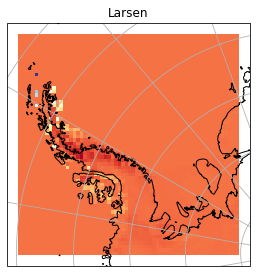

In [14]:
f = plt.figure(figsize=(20, 5))
i = 1
for r in REGIONS:
    targets, target_times = target_maker(target_dataset, region=r, resize=False)
    full_target_test = np.concatenate(targets, axis=0)[0, :, :, :]
    ax = plt.subplot(1, 4, i, projection=ccrs.SouthPolarStereo())
    vmin = np.min(full_target_test)
    vmax = np.max(full_target_test)
    plotTarget(target_dataset, full_target_test, ax, vmin, vmax, region=r)
    ax.set_title(r)
    i += 1

### Examples of input to model:
Show an example of process of how dataset is

2D Feature batch shape: torch.Size([32, 8, 32, 32])
1D Feature batch shape: torch.Size([32, 19, 1, 1])
Labels batch shape: torch.Size([32, 1, 64, 64])


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

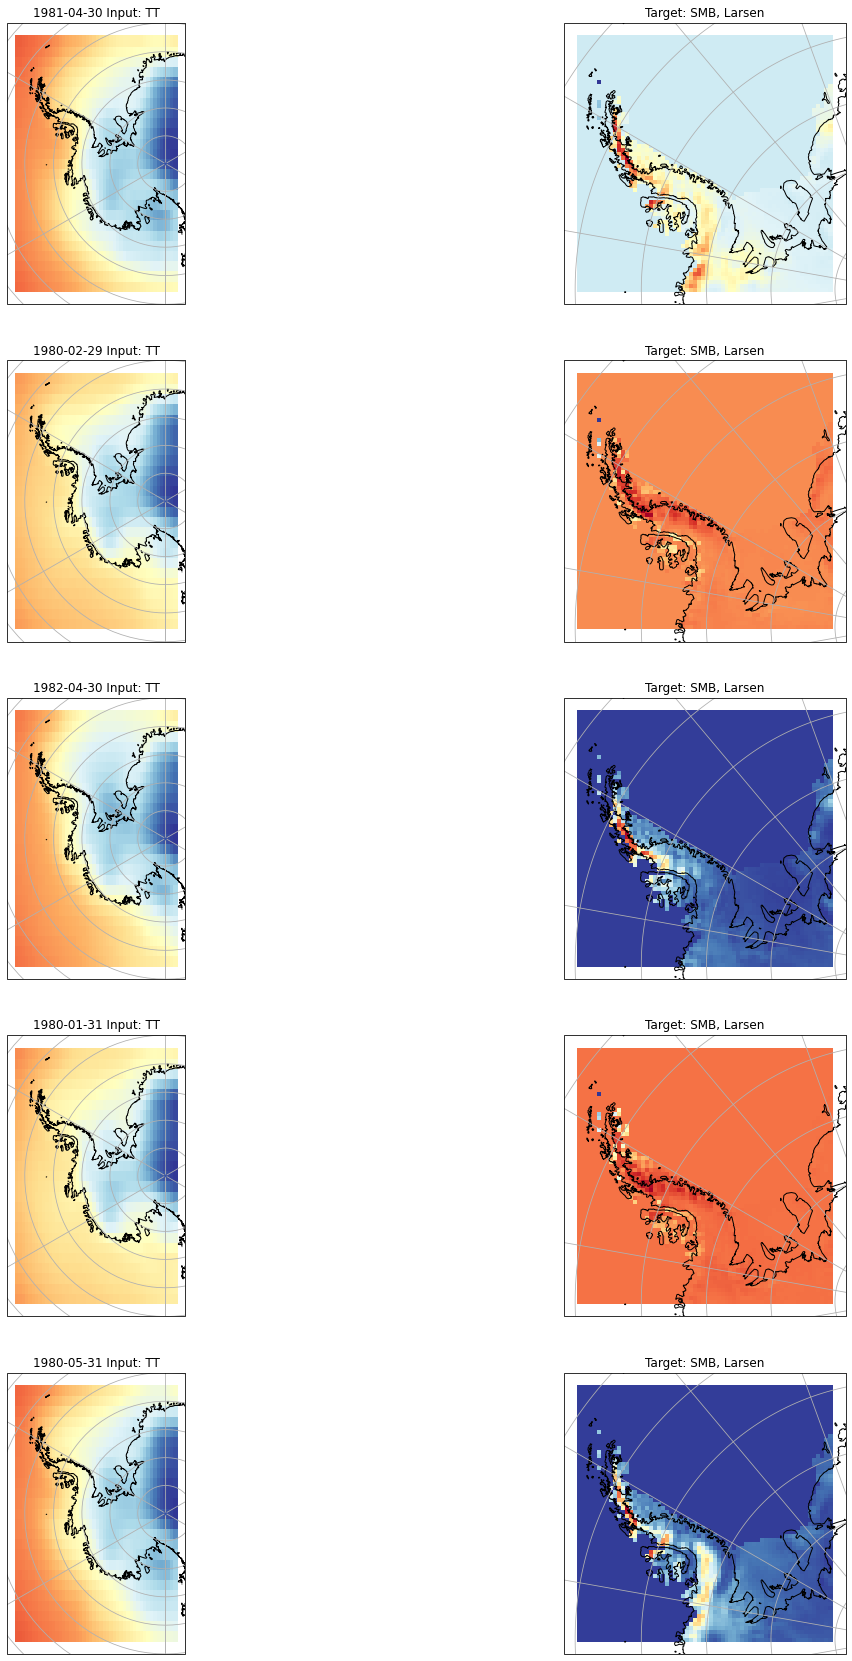

In [15]:
#  Create pytorch tensors:
X = torch.tensor(full_input[0].transpose(0, 3, 1, 2))
Z = torch.tensor(full_input[1].transpose(0, 3, 1, 2))
Y = torch.tensor(full_target.transpose(0, 3, 1, 2))
R = regionEncoder(X, REGION) # region encoder
X.shape, Z.shape, Y.shape, len(R)

# 1. Create dataset
dataset = TensorDataset(X, Z, Y, R)
loader = DataLoader(dataset, batch_size=BATCH_SIZE)

# Example:
(x, z, y, r) = next(iter(loader))
print(f"2D Feature batch shape: {x.size()}")
print(f"1D Feature batch shape: {z.size()}")
print(f"Labels batch shape: {y.size()}")

# 2. Split into train / validation partitions
n_val = int(len(dataset) * VAL_PERCENT)
n_train = len(dataset) - n_val
train_set, val_set = random_split(
    dataset, [n_train, n_val], generator=torch.Generator().manual_seed(SEED)
)

# 3. Create data loaders
loader_args = dict(batch_size=BATCH_SIZE)
train_loader = DataLoader(train_set, shuffle=False, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_set, shuffle=False, batch_size=BATCH_SIZE)

# 4. Display input and targets.
N = 5 
f = plt.figure(figsize=(20, 30))

for i in range(N):
  train_X, train_Z, train_Y, train_R = next(iter(loader))
  randTime = rn.randint(0, len(train_X)-1)
  sample2dtrain_ = train_X.numpy().transpose(0, 2, 3, 1)[randTime]
  sampletarget_ = train_Y.numpy().transpose(0, 2, 3, 1)[randTime]
  sampleregion = train_R[randTime]
  dt = pd.to_datetime([GCMLike.time.isel(time=randTime).values])
  time = str(dt.date[0])

  if REGION != "Whole Antarctica":
      sample2dtrain_ = resize(sample2dtrain_, 25, 48, print_=False)
  else:
      sample2dtrain_ = resize(sample2dtrain_, 25, 90, print_=False)
  vmin = np.min(sampletarget_)
  vmax = np.max(sampletarget_)

  M = 2
  for m in range(M):
    if m == 0:
      ax = plt.subplot(N, 2, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
      plotTrain(GCMLike, sample2dtrain_, 4, ax, time, VAR_LIST, region=REGIONS[sampleregion])
    if m == 1:
      ax = plt.subplot(N, 2, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
      plotTarget(target_dataset, sampletarget_, ax, vmin, vmax, region=REGIONS[sampleregion])

## U-Net:

In [28]:
from unet import *
from SmaAt_UNet import *

In [29]:
from dataFunctions import *
from makeInputs import *
from config import *
from training_functions import *
from metrics import *
from unet import *

## Training

In [30]:
torch.manual_seed(SEED)

### Scenario 1: 1 region

#### Larsen:

In [81]:
from dataFunctions import *
from makeInputs import *
from config import *
from training_functions import *
from metrics import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
REGION = "Larsen"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]

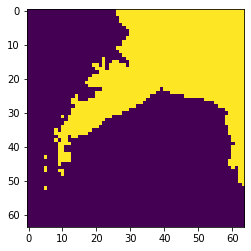

In [83]:
mask = createMask(full_target[0,:,:], onechannel = True)
plt.imshow(mask)

##### MSE:

In [ ]:
%%time
NUM_EPOCHS = 30
LOSS_ = 'MSE'
TYPENET = 'Baseline'
# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT, 
    loss_ = LOSS_, 
    typeNet = TYPENET,
    ignoreSea = False,
    nrmse_maxmin = True, # normalise by (max-min) or by mean of target
    earlystopping = 5,
)
print(trainingParam)
# Load datasets and U-Net 
train_loss_e, val_loss_e, train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    torch.tensor(mask),
    region=REGION,
    train=True, # train True so that actually trains
    randomSplit = False, # don't take random time samples but take future as test, 
    **trainingParam
)

INFO: Using device cuda
INFO: Baseline model


{'num_epochs': 30, 'batch_size': 32, 'lr': 0.01, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'MSE', 'typeNet': 'Baseline', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 5}


INFO: Network:
	8 input channels X
	19 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 8, 32, 32])


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▇▅█▆▆▆▅▄▃▂▃▂▃▃▄▄▃▂▂▃▃▂▄▃▂▂▂▃▂▃▂▃▂▃▃▁▁▁▂
validation mse,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,11
learning rate,0.01
step,363
train loss,0.01082
validation mse,0.01044


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.01
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:12<00:00, 85.17timestep/s, loss (batch)=1.68] 
INFO: Checkpoint 2 saved!
Epoch 3/30: 100%|██████████| 1046/1046 [00:12<00:00, 86.41timestep/s, loss (batch)=1.58] 
INFO: Checkpoint 3 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:12<00:00, 82.34timestep/s, loss (batch)=1.49]
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:12<00:00, 85.62timestep/s, loss (batch)=1.41] 
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:12<00:00, 85.52timestep/s, loss (batch)=1.23]
INFO: Checkpoint 6 saved!
Epoch 7/30: 100%|██████████| 1046/1046 [00:12<00:00, 85.77timestep/s, loss (batch)=0.942]
INFO: Checkpoint 7 saved!
Epoch 8/30: 100%|██████████| 1046/1046 [00:12<00:00, 85.90timestep/s, loss (batch)=0.795]
I

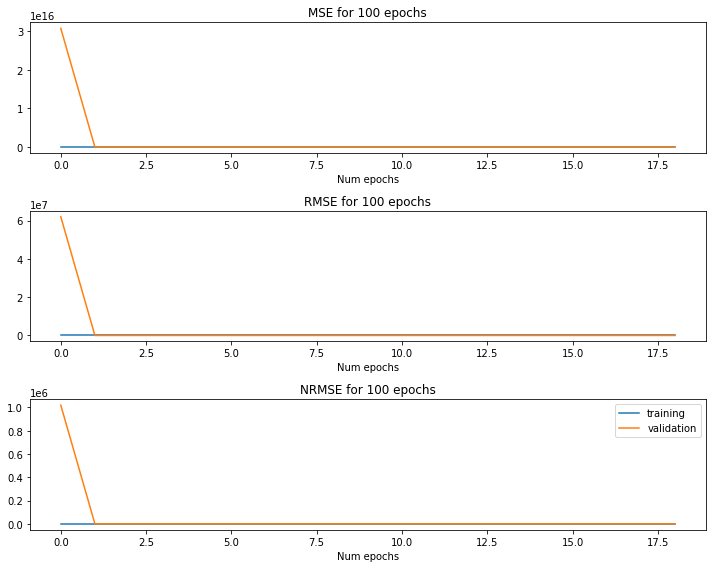

In [91]:
plotLoss(train_loss_e, val_loss_e)

##### NRMSE:

In [86]:
%%time
NUM_EPOCHS = 30
LOSS_ = 'NRMSE'
TYPENET = 'Attention'
LR = 0.01
# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT, 
    loss_ = LOSS_, 
    typeNet = TYPENET,
    ignoreSea = False,
    nrmse_maxmin = True, # normalise by (max-min) or by mean of target
    earlystopping = 5,
)
print(trainingParam)
# Load datasets and U-Net 
train_loss_e, val_loss_e, train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    torch.tensor(mask),
    region=REGION,
    train=True, # train True so that actually trains
    randomSplit = False, # don't take random time samples but take future as test, 
    **trainingParam
)

INFO: Using device cuda
INFO: Attention SmAt_UNet model


{'num_epochs': 30, 'batch_size': 32, 'lr': 0.01, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'NRMSE', 'typeNet': 'Attention', 'ignoreSea': False, 'nrmse_maxmin': True, 'earlystopping': 5}


INFO: Network:
	8 input channels X
	19 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 8, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▅▃▄▅▆▃▃▂▂▁▂▃▂▁▂▂▃▁▁▁▁▁▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▂
validation mse,█▇▅▃▃▄▃▂▂▂▁▆▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁
epoch,13
learning rate,0.01
step,429
train loss,0.3874
validation mse,0.40884


INFO: Starting training:
		Epochs:          30
		Batch size:      32
		Learning rate:   0.01
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 2/30: 100%|██████████| 1046/1046 [00:11<00:00, 92.11timestep/s, loss (batch)=0.0186] 
INFO: Checkpoint 2 saved!
Epoch 4/30: 100%|██████████| 1046/1046 [00:11<00:00, 92.63timestep/s, loss (batch)=0.0132] 
INFO: Checkpoint 4 saved!
Epoch 5/30: 100%|██████████| 1046/1046 [00:11<00:00, 91.29timestep/s, loss (batch)=0.0126] 
INFO: Checkpoint 5 saved!
Epoch 6/30: 100%|██████████| 1046/1046 [00:11<00:00, 92.21timestep/s, loss (batch)=0.012] 
INFO: Checkpoint 6 saved!
Epoch 11/30: 100%|██████████| 1046/1046 [00:11<00:00, 91.08timestep/s, loss (batch)=0.0108] 
INFO: Stopping early --> mean val score 0.015843655914068222 has not decreased over 5 epochs compared to best 0.01565385051071644 
INFO: Saving model on google drive


CPU times: user 1min 7s, sys: 1min 4s, total: 2min 12s
Wall time: 2min 20s


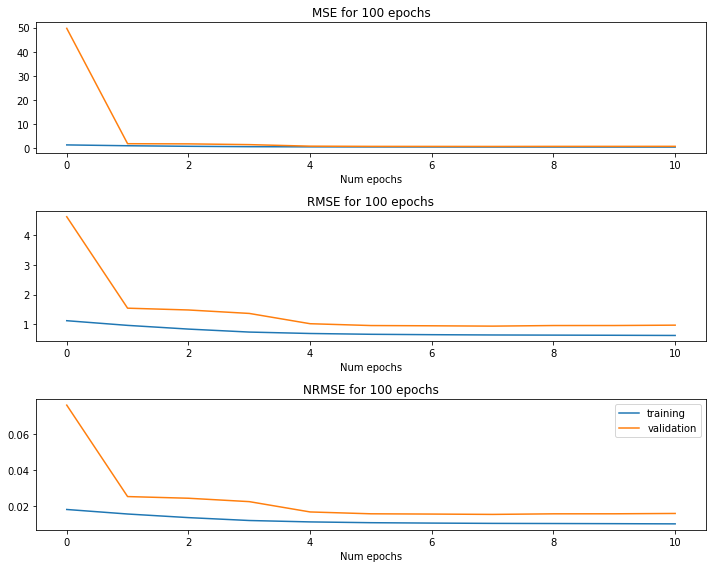

In [88]:
plotLoss(train_loss_e, val_loss_e)

##### RMSE:

In [ ]:
%%time
NUM_EPOCHS = 100
TYPENET = 'Attention'
LOSS_ = 'RMSE'
# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT, 
    loss_ = LOSS_, 
    typeNet = TYPENET
)
print(trainingParam)
# Load datasets and U-Net 
train_loss_e, val_loss_e, train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=True, # train True so that actually trains
    randomSplit = False, # don't take random time samples but take future as test, 
    **trainingParam
)

INFO: Using device cuda
INFO: Attention SmAt_UNet model


{'num_epochs': 100, 'batch_size': 32, 'lr': 0.005, 'seed': 123, 'amp': False, 'test_percent': 0.1, 'val_percent': 0.2, 'loss_': 'RMSE', 'typeNet': 'Attention'}


INFO: Network:
	7 input channels X
	17 input channels Z
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 1046
Validation set size: 261



X shape: torch.Size([1452, 7, 32, 32])


INFO: Starting training:
		Epochs:          100
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 1/100: 100%|██████████| 1046/1046 [00:13<00:00, 77.85timestep/s, loss (batch)=1.21]
INFO: Checkpoint 1 saved!
Epoch 2/100: 100%|██████████| 1046/1046 [00:14<00:00, 73.78timestep/s, loss (batch)=0.951]
INFO: Checkpoint 2 saved!
Epoch 3/100:  18%|█▊        | 192/1046 [00:01<00:07, 112.41timestep/s, loss (batch)=0.889]

Epoch 00024: reducing learning rate of group 0 to 5.0000e-04.


Epoch 3/100: 100%|██████████| 1046/1046 [00:13<00:00, 75.21timestep/s, loss (batch)=0.863]
INFO: Checkpoint 3 saved!
Epoch 4/100:  98%|█████████▊| 1024/1046 [00:12<00:00, 68.61timestep/s, loss (batch)=0.697]

Epoch 00043: reducing learning rate of group 0 to 5.0000e-05.


Epoch 4/100: 100%|██████████| 1046/1046 [00:13<00:00, 77.00timestep/s, loss (batch)=0.838]
INFO: Checkpoint 4 saved!
Epoch 5/100: 100%|██████████| 1046/1046 [00:13<00:00, 77.88timestep/s, loss (batch)=0.828]
INFO: Checkpoint 5 saved!
Epoch 6/100:  15%|█▌        | 160/1046 [00:01<00:13, 64.26timestep/s, loss (batch)=0.69] 

Epoch 00056: reducing learning rate of group 0 to 5.0000e-06.


Epoch 6/100:  61%|██████    | 640/1046 [00:07<00:05, 69.50timestep/s, loss (batch)=0.608]

Epoch 00061: reducing learning rate of group 0 to 5.0000e-07.


Epoch 6/100: 100%|██████████| 1046/1046 [00:12<00:00, 98.17timestep/s, loss (batch)=0.825]

Epoch 00066: reducing learning rate of group 0 to 5.0000e-08.


Epoch 6/100: 100%|██████████| 1046/1046 [00:13<00:00, 78.04timestep/s, loss (batch)=0.825]
INFO: Checkpoint 6 saved!
Epoch 7/100:  52%|█████▏    | 544/1046 [00:06<00:07, 68.42timestep/s, loss (batch)=0.712]

Epoch 00071: reducing learning rate of group 0 to 5.0000e-09.


Epoch 7/100: 100%|██████████| 1046/1046 [00:13<00:00, 76.78timestep/s, loss (batch)=0.825]
INFO: Checkpoint 7 saved!
Epoch 8/100: 100%|██████████| 1046/1046 [00:13<00:00, 77.52timestep/s, loss (batch)=0.825]
INFO: Checkpoint 8 saved!
Epoch 9/100: 100%|██████████| 1046/1046 [00:13<00:00, 77.67timestep/s, loss (batch)=0.825]
INFO: Checkpoint 9 saved!
Epoch 10/100: 100%|██████████| 1046/1046 [00:13<00:00, 77.32timestep/s, loss (batch)=0.825]
INFO: Checkpoint 10 saved!
Epoch 11/100: 100%|██████████| 1046/1046 [00:13<00:00, 76.45timestep/s, loss (batch)=0.825]
INFO: Checkpoint 11 saved!
Epoch 12/100: 100%|██████████| 1046/1046 [00:13<00:00, 77.68timestep/s, loss (batch)=0.825]
INFO: Checkpoint 12 saved!
Epoch 13/100: 100%|██████████| 1046/1046 [00:13<00:00, 77.72timestep/s, loss (batch)=0.825]
INFO: Checkpoint 13 saved!
Epoch 14/100: 100%|██████████| 1046/1046 [00:13<00:00, 76.73timestep/s, loss (batch)=0.825]
INFO: Checkpoint 14 saved!
Epoch 15/100: 100%|██████████| 1046/1046 [00:13<00:00,

CPU times: user 9min 34s, sys: 11min 14s, total: 20min 49s
Wall time: 21min 16s


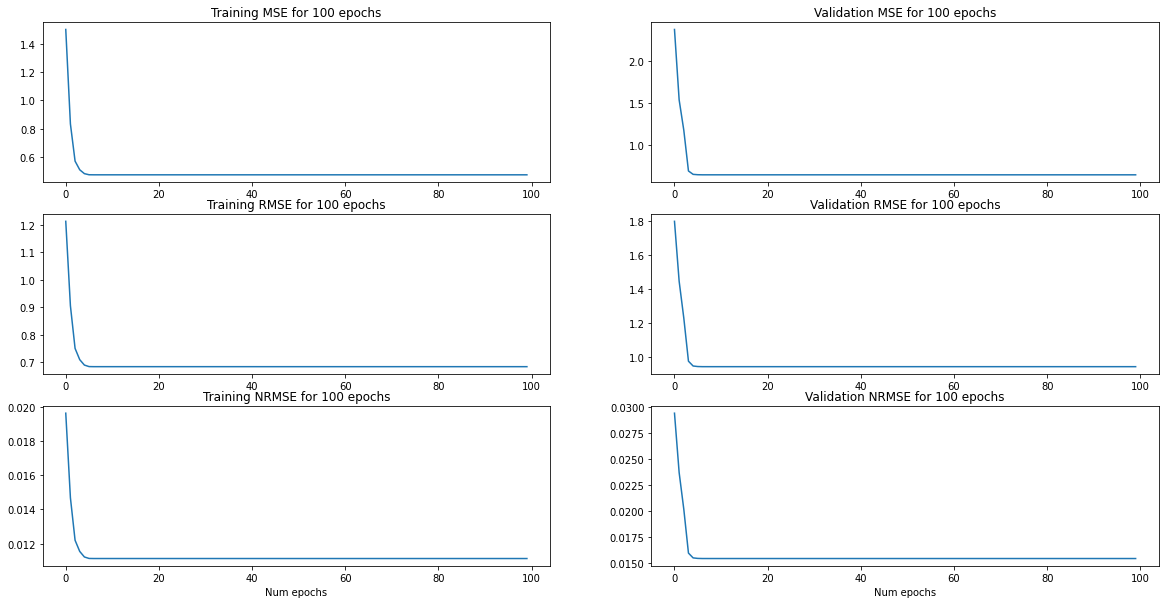

In [ ]:
plotLoss(train_loss_e, val_loss_e)

#### Maud:

In [ ]:
REGION = "Maud"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]
# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT,
    typeNet = 'Variance',
    loss = 'MSE'
)

In [ ]:
%%time
# Load datasets and U-Net
train_loss_e, val_loss_e, train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=True, # train True so that actually trains
    randomSplit = False, # don't take random time samples but take future as test
    **trainingParam
)

In [ ]:
plotLoss(train_loss_e, val_loss_e)

#### Wilkes

In [ ]:
REGION = "Wilkes"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]
# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT,
    typeNet = 'Variance',
    loss = 'MSE'
)

In [ ]:
%%time
# Load datasets and U-Net
train_loss_e, val_loss_e, train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=True, # train True so that actually trains
    randomSplit = False, # don't take random time samples but take future as test
    **trainingParam
)

INFO: Using device cuda
INFO: Variance model
INFO: Network:
	14 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 261
Validation set size: 1046



X shape: torch.Size([1452, 14, 32, 32])


wandb: Currently logged in as: anony-mouse-255206. Use `wandb login --relogin` to force relogin


INFO: Starting training:
		Epochs:          100
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 1/100: 100%|██████████| 1046/1046 [00:18<00:00, 56.51timestep/s, loss (batch)=0.456]
INFO: Checkpoint 1 saved!
Epoch 2/100: 100%|██████████| 1046/1046 [00:18<00:00, 57.64timestep/s, loss (batch)=0.338]
INFO: Checkpoint 2 saved!
Epoch 3/100: 100%|██████████| 1046/1046 [00:18<00:00, 56.96timestep/s, loss (batch)=0.187]
INFO: Checkpoint 3 saved!
Epoch 4/100: 100%|██████████| 1046/1046 [00:18<00:00, 56.89timestep/s, loss (batch)=0.498]
INFO: Checkpoint 4 saved!
Epoch 5/100:  76%|███████▋  | 800/1046 [00:13<00:05, 48.79timestep/s, loss (batch)=0.521]

Epoch 00052: reducing learning rate of group 0 to 5.0000e-04.


Epoch 5/100: 100%|██████████| 1046/1046 [00:18<00:00, 57.33timestep/s, loss (batch)=0.235]
INFO: Checkpoint 5 saved!
Epoch 6/100: 100%|██████████| 1046/1046 [00:18<00:00, 57.10timestep/s, loss (batch)=0.32]
INFO: Checkpoint 6 saved!
Epoch 7/100:  21%|██▏       | 224/1046 [00:03<00:17, 47.77timestep/s, loss (batch)=0.266]

Epoch 00068: reducing learning rate of group 0 to 5.0000e-05.


Epoch 7/100: 100%|██████████| 1046/1046 [00:18<00:00, 57.10timestep/s, loss (batch)=0.188]
INFO: Checkpoint 7 saved!
Epoch 8/100:  95%|█████████▍| 992/1046 [00:16<00:01, 46.97timestep/s, loss (batch)=0.339]

Epoch 00087: reducing learning rate of group 0 to 5.0000e-06.


Epoch 8/100: 100%|██████████| 1046/1046 [00:18<00:00, 56.66timestep/s, loss (batch)=0.193]
INFO: Checkpoint 8 saved!
Epoch 9/100:  86%|████████▌ | 896/1046 [00:15<00:03, 47.47timestep/s, loss (batch)=0.291]

Epoch 00097: reducing learning rate of group 0 to 5.0000e-07.


Epoch 9/100: 100%|██████████| 1046/1046 [00:18<00:00, 57.02timestep/s, loss (batch)=0.201]
INFO: Checkpoint 9 saved!
Epoch 10/100:  31%|███       | 320/1046 [00:05<00:15, 47.37timestep/s, loss (batch)=0.247]

Epoch 00102: reducing learning rate of group 0 to 5.0000e-08.


Epoch 10/100:  95%|█████████▍| 992/1046 [00:16<00:01, 46.41timestep/s, loss (batch)=0.223]

Epoch 00109: reducing learning rate of group 0 to 5.0000e-09.


Epoch 10/100: 100%|██████████| 1046/1046 [00:18<00:00, 56.44timestep/s, loss (batch)=0.211]
INFO: Checkpoint 10 saved!
Epoch 11/100: 100%|██████████| 1046/1046 [00:19<00:00, 55.02timestep/s, loss (batch)=0.205]
INFO: Checkpoint 11 saved!
Epoch 12/100: 100%|██████████| 1046/1046 [00:18<00:00, 56.97timestep/s, loss (batch)=0.243]
INFO: Checkpoint 12 saved!
Epoch 13/100: 100%|██████████| 1046/1046 [00:18<00:00, 56.88timestep/s, loss (batch)=0.302]
INFO: Checkpoint 13 saved!
Epoch 14/100: 100%|██████████| 1046/1046 [00:18<00:00, 56.65timestep/s, loss (batch)=0.188]
INFO: Checkpoint 14 saved!
Epoch 15/100: 100%|██████████| 1046/1046 [00:18<00:00, 56.71timestep/s, loss (batch)=0.235]
INFO: Checkpoint 15 saved!
Epoch 16/100: 100%|██████████| 1046/1046 [00:18<00:00, 56.69timestep/s, loss (batch)=0.175]
INFO: Checkpoint 16 saved!
Epoch 17/100: 100%|██████████| 1046/1046 [00:18<00:00, 56.73timestep/s, loss (batch)=0.186]
INFO: Checkpoint 17 saved!
Epoch 18/100: 100%|██████████| 1046/1046 [00:18<

CPU times: user 17min 39s, sys: 16min 45s, total: 34min 24s
Wall time: 33min 22s


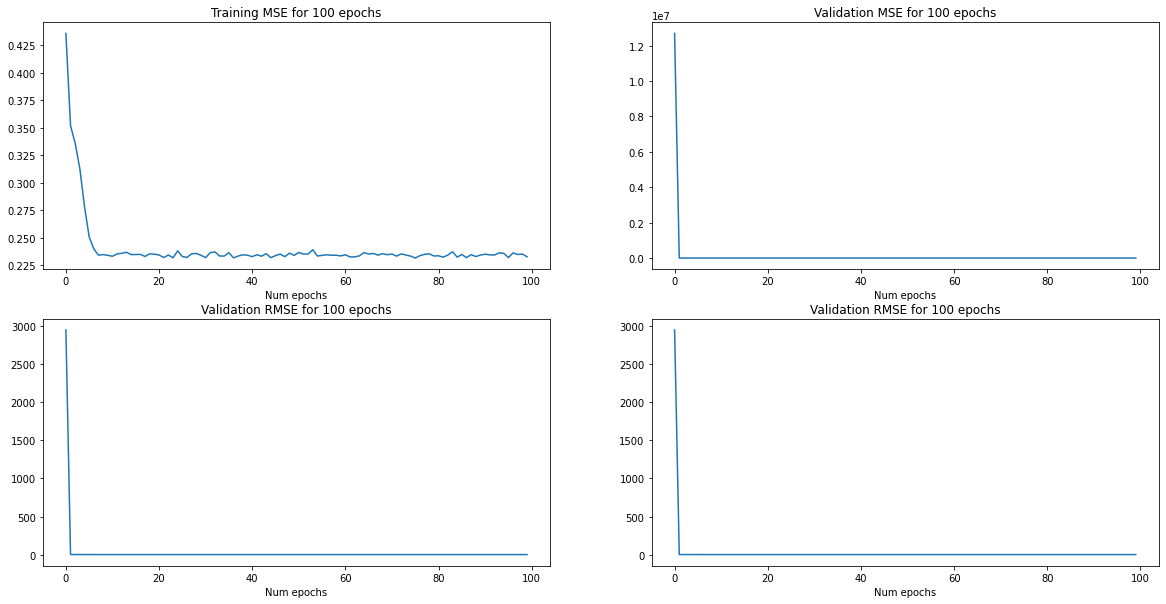

In [ ]:
plotLoss(train_loss_e, val_loss_e)

#### Amundsen:

In [ ]:
REGION = "Amundsen"
# Make target
targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

# Make input
i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
    GCMLike, 
    size_input_domain=SIZE_INPUT_DOMAIN, 
    Region=REGION, 
    regionNbr=0
)
full_input = [np.concatenate([i2D], axis=0), np.concatenate([i1D], axis=0)]
full_input_ns = [
    np.concatenate([i2D_ns], axis=0),
    np.concatenate([i1D_ns], axis=0),
]

REGIONS = [REGION]
# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT,
    typeNet = 'Variance',
    loss = 'MSE'
)

In [ ]:
%%time
# Load datasets and U-Net
train_loss_e, val_loss_e, train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=True, # train True so that actually trains
    randomSplit = False, # don't take random time samples but take future as test
    **trainingParam
)

INFO: Using device cuda
INFO: Variance model
INFO: Network:
	14 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 145
Train set size: 1307

INFO: Train set size: 261
Validation set size: 1046



X shape: torch.Size([1452, 14, 32, 32])


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning rate,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,▃▅▂▄▄▃▂▄▄▂▃▃▂▂▄▅▄█▃█▅▅▂█▄▃▃▄▂▂▄▄▄▂▂▆▁▆▂▄
validation mse,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
learning rate,0.0
step,3300
train loss,0.15296
validation mse,0.22584


INFO: Starting training:
		Epochs:          100
		Batch size:      32
		Learning rate:   0.005
		Training size:   1046
		Validation size: 261
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 1/100: 100%|██████████| 1046/1046 [00:20<00:00, 49.87timestep/s, loss (batch)=1.13]
INFO: Checkpoint 1 saved!
Epoch 2/100: 100%|██████████| 1046/1046 [00:21<00:00, 49.67timestep/s, loss (batch)=0.737]
INFO: Checkpoint 2 saved!
Epoch 3/100: 100%|██████████| 1046/1046 [00:20<00:00, 50.30timestep/s, loss (batch)=0.574]
INFO: Checkpoint 3 saved!
Epoch 4/100:  31%|███       | 320/1046 [00:06<00:17, 41.68timestep/s, loss (batch)=0.611]

Epoch 00036: reducing learning rate of group 0 to 5.0000e-04.


Epoch 4/100: 100%|██████████| 1046/1046 [00:20<00:00, 49.97timestep/s, loss (batch)=0.651]
INFO: Checkpoint 4 saved!
Epoch 5/100:  40%|███▉      | 416/1046 [00:08<00:14, 42.59timestep/s, loss (batch)=0.631]

Epoch 00048: reducing learning rate of group 0 to 5.0000e-05.


Epoch 5/100: 100%|██████████| 1046/1046 [00:20<00:00, 50.82timestep/s, loss (batch)=0.47]
INFO: Checkpoint 5 saved!
Epoch 6/100:  40%|███▉      | 416/1046 [00:08<00:14, 42.09timestep/s, loss (batch)=0.621]

Epoch 00059: reducing learning rate of group 0 to 5.0000e-06.


Epoch 6/100: 100%|██████████| 1046/1046 [00:20<00:00, 50.42timestep/s, loss (batch)=0.498]
INFO: Checkpoint 6 saved!
Epoch 7/100:  49%|████▉     | 512/1046 [00:09<00:12, 42.56timestep/s, loss (batch)=0.612]

Epoch 00071: reducing learning rate of group 0 to 5.0000e-07.


Epoch 7/100: 100%|██████████| 1046/1046 [00:21<00:00, 49.49timestep/s, loss (batch)=0.527]
INFO: Checkpoint 7 saved!
Epoch 8/100:  76%|███████▋  | 800/1046 [00:15<00:05, 41.73timestep/s, loss (batch)=0.489]

Epoch 00085: reducing learning rate of group 0 to 5.0000e-08.


Epoch 8/100: 100%|██████████| 1046/1046 [00:20<00:00, 50.32timestep/s, loss (batch)=0.499]
INFO: Checkpoint 8 saved!
Epoch 9/100:  21%|██▏       | 224/1046 [00:04<00:19, 41.64timestep/s, loss (batch)=0.662]

Epoch 00090: reducing learning rate of group 0 to 5.0000e-09.


Epoch 9/100: 100%|██████████| 1046/1046 [00:20<00:00, 50.58timestep/s, loss (batch)=0.589]
INFO: Checkpoint 9 saved!
Epoch 10/100: 100%|██████████| 1046/1046 [00:20<00:00, 49.93timestep/s, loss (batch)=0.737]
INFO: Checkpoint 10 saved!
Epoch 11/100: 100%|██████████| 1046/1046 [00:20<00:00, 50.59timestep/s, loss (batch)=0.515]
INFO: Checkpoint 11 saved!
Epoch 12/100: 100%|██████████| 1046/1046 [00:20<00:00, 51.91timestep/s, loss (batch)=0.521]
INFO: Checkpoint 12 saved!
Epoch 13/100: 100%|██████████| 1046/1046 [00:20<00:00, 51.29timestep/s, loss (batch)=0.535]
INFO: Checkpoint 13 saved!
Epoch 14/100: 100%|██████████| 1046/1046 [00:19<00:00, 53.03timestep/s, loss (batch)=0.662]
INFO: Checkpoint 14 saved!
Epoch 15/100: 100%|██████████| 1046/1046 [00:19<00:00, 53.12timestep/s, loss (batch)=0.445]
INFO: Checkpoint 15 saved!
Epoch 16/100: 100%|██████████| 1046/1046 [00:19<00:00, 54.72timestep/s, loss (batch)=0.697]
INFO: Checkpoint 16 saved!
Epoch 17/100: 100%|██████████| 1046/1046 [00:19<00

CPU times: user 17min 37s, sys: 18min 29s, total: 36min 7s
Wall time: 34min 45s


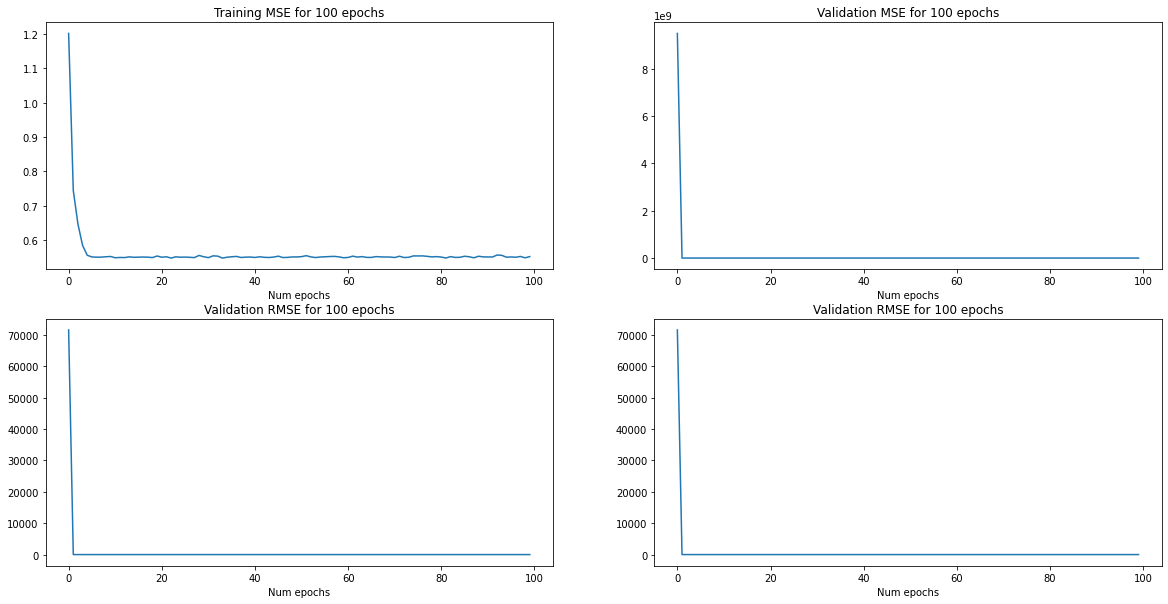

In [ ]:
plotLoss(train_loss_e, val_loss_e)

### Scenario 2: Multiple regions

In [ ]:
from dataFunctions import *
from makeInputs import *
from config import *
from training_functions import *

In [ ]:
REGION = 'Combined'
REGIONS

['Larsen', 'Wilkes', 'Maud', 'Amundsen']

In [ ]:
# Make input
inputs_2D = []
inputs_1D = []
inputs_2D_ns = []
inputs_1D_ns = []
i = 0
for r in REGIONS:
  i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
            GCMLike, SIZE_INPUT_DOMAIN, Region=r, regionNbr=i
        )
  inputs_1D.append(i1D)
  inputs_2D.append(i2D)
  inputs_1D_ns.append(i1D_ns)
  inputs_2D_ns.append(i2D_ns)
  i+=1

# Full input to model
full_input = [np.concatenate(inputs_2D, axis=0), np.concatenate(inputs_1D, axis=0)]
full_input_ns = [
    np.concatenate(inputs_2D_ns, axis=0),
    np.concatenate(inputs_1D_ns, axis=0),
]

# Make target:
targets, target_times = [], []
for r in REGIONS:
  t, t_times = target_maker(target_dataset, region=r, resize=False)
  targets.append(t[0])
  target_times.append(t_times[0])

# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

print("Shapes of targets and inputs:\n---------------------------")
print("Target:", full_target.shape)
print("Input 2D:", full_input[0].shape)
print("Input 1D:", full_input[1].shape)


# Parameters used in training
trainingParam = dict(
    num_epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    lr=LR,
    seed=SEED, 
    amp=AMP,
    test_percent = TEST_PERCENT,
    val_percent = VAL_PERCENT, 
    loss = 'MSE'
)

Shapes of targets and inputs:
---------------------------
Target: (5808, 64, 64, 1)
Input 2D: (5808, 32, 32, 7)
Input 1D: (5808, 1, 1, 17)


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


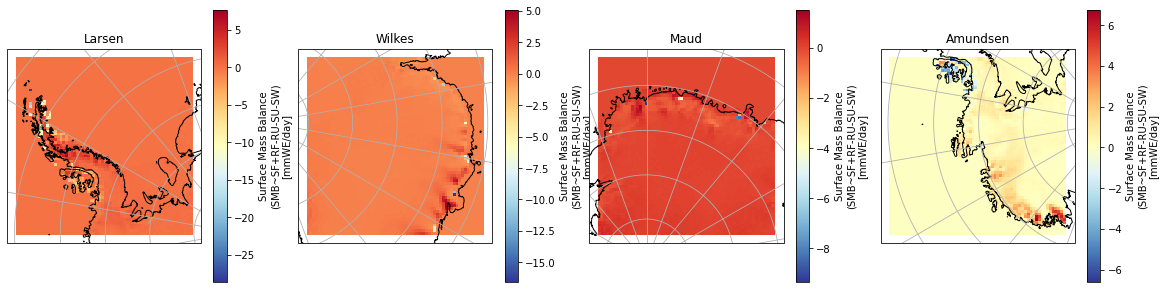

In [ ]:
f = plt.figure(figsize=(20, 5))
i = 1
for r in REGIONS:
    targets, target_times = target_maker(target_dataset, region=r, resize=False)
    full_target_test = np.concatenate(targets, axis=0)[0, :, :, :]
    ax = plt.subplot(1, 4, i, projection=ccrs.SouthPolarStereo())
    vmin = np.min(full_target_test)
    vmax = np.max(full_target_test)
    plotTarget(target_dataset, full_target_test, ax, vmin, vmax, region=r)
    ax.set_title(r)
    i += 1

In [ ]:
%%time
# Load datasets and U-Net
train_loss_e, val_loss_e, train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    regions = REGIONS,
    train=True, # train True so that actually trains
    randomSplit = False, # don't take random time samples but take future as test
    **trainingParam
)

INFO: Using device cuda
INFO: Network:
	7 input channels X
	17 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 580
Train set size: 5228

INFO: Train set size: 1045
Validation set size: 4183



<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO: Starting training:
		Epochs:          300
		Batch size:      32
		Learning rate:   0.005
		Training size:   4183
		Validation size: 1045
		Checkpoints:     True
		Device:          cuda
		Mixed Precision: False
	
Epoch 1/300: 100%|██████████| 4183/4183 [00:27<00:00, 150.21timestep/s, loss (batch)=0.668]
INFO: Checkpoint 1 saved!
Epoch 2/300:  60%|██████    | 2528/4183 [00:16<00:19, 85.42timestep/s, loss (batch)=0.871]

Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 2/300: 100%|██████████| 4183/4183 [00:27<00:00, 152.70timestep/s, loss (batch)=0.556]
INFO: Checkpoint 2 saved!
Epoch 3/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.11timestep/s, loss (batch)=1.22]
INFO: Checkpoint 3 saved!
Epoch 4/300: 100%|██████████| 4183/4183 [00:27<00:00, 152.47timestep/s, loss (batch)=0.799]
INFO: Checkpoint 4 saved!
Epoch 5/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.41timestep/s, loss (batch)=0.8]
INFO: Checkpoint 5 saved!
Epoch 6/300: 100%|██████████| 4183/4183 [00:27<00:00, 151.84timestep/s, loss (batch)=0.819]
INFO: Checkpoint 6 saved!
Epoch 7/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.03timestep/s, loss (batch)=0.877]
INFO: Checkpoint 7 saved!
Epoch 8/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.44timestep/s, loss (batch)=1.07]
INFO: Checkpoint 8 saved!
Epoch 9/300: 100%|██████████| 4183/4183 [00:27<00:00, 152.76timestep/s, loss (batch)=1.33]
INFO: Checkpoint 9 saved!
Epoch 10/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.70

Epoch 00115: reducing learning rate of group 0 to 5.0000e-05.


Epoch 12/300: 100%|██████████| 4183/4183 [00:27<00:00, 151.35timestep/s, loss (batch)=0.457]
INFO: Checkpoint 12 saved!
Epoch 13/300: 100%|██████████| 4183/4183 [00:28<00:00, 148.36timestep/s, loss (batch)=0.527]
INFO: Checkpoint 13 saved!
Epoch 14/300: 100%|██████████| 4183/4183 [00:26<00:00, 155.85timestep/s, loss (batch)=0.868]
INFO: Checkpoint 14 saved!
Epoch 15/300:  40%|███▉      | 1664/4183 [00:10<00:30, 81.90timestep/s, loss (batch)=0.602]

Epoch 00145: reducing learning rate of group 0 to 5.0000e-06.


Epoch 15/300:  90%|█████████ | 3776/4183 [00:24<00:04, 92.90timestep/s, loss (batch)=0.771]

Epoch 00150: reducing learning rate of group 0 to 5.0000e-07.


Epoch 15/300: 100%|██████████| 4183/4183 [00:26<00:00, 155.28timestep/s, loss (batch)=0.907]
INFO: Checkpoint 15 saved!
Epoch 16/300:  39%|███▉      | 1632/4183 [00:10<00:33, 75.74timestep/s, loss (batch)=0.56] 

Epoch 00155: reducing learning rate of group 0 to 5.0000e-08.


Epoch 16/300:  89%|████████▊ | 3712/4183 [00:24<00:06, 73.69timestep/s, loss (batch)=0.694]

Epoch 00160: reducing learning rate of group 0 to 5.0000e-09.


Epoch 16/300: 100%|██████████| 4183/4183 [00:27<00:00, 153.11timestep/s, loss (batch)=0.762]
INFO: Checkpoint 16 saved!
Epoch 17/300: 100%|██████████| 4183/4183 [00:27<00:00, 154.75timestep/s, loss (batch)=0.642]
INFO: Checkpoint 17 saved!
Epoch 18/300: 100%|██████████| 4183/4183 [00:26<00:00, 154.99timestep/s, loss (batch)=0.526]
INFO: Checkpoint 18 saved!
Epoch 19/300: 100%|██████████| 4183/4183 [00:28<00:00, 148.60timestep/s, loss (batch)=0.814]
INFO: Checkpoint 19 saved!
Epoch 20/300: 100%|██████████| 4183/4183 [00:27<00:00, 149.54timestep/s, loss (batch)=0.423]
INFO: Checkpoint 20 saved!
Epoch 21/300: 100%|██████████| 4183/4183 [00:27<00:00, 149.90timestep/s, loss (batch)=0.777]
INFO: Checkpoint 21 saved!
Epoch 22/300: 100%|██████████| 4183/4183 [00:27<00:00, 149.60timestep/s, loss (batch)=0.818]
INFO: Checkpoint 22 saved!
Epoch 23/300: 100%|██████████| 4183/4183 [00:27<00:00, 149.74timestep/s, loss (batch)=0.706]
INFO: Checkpoint 23 saved!
Epoch 24/300: 100%|██████████| 4183/4183

RuntimeError: ignored

In [ ]:
# Load saved model
#today = str(date.today())
# Load datasets and U-Net
train_set, test_set, net = trainFlow(
    full_input,
    full_target,
    region=REGION,
    train=False,
    randomSplit = True,
    **trainingParam
)
loader_args = dict(batch_size=1, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=False, **loader_args)

#today = '2022-05-05'
#today = date.today()
today = '2022-05-05'
model = f"MODEL_{today}_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"
downloadModel = True
if downloadModel:
    #downloadFileFromGC(pathModel, "", model)
    # Download from google drive
    linkModel = 'https://drive.google.com/file/d/1rooLD6OJQX3YmJq-WqRm1ya6j8cLm48a/view?usp=sharing'
    idModel = '1rooLD6OJQX3YmJq-WqRm1ya6j8cLm48a'
    downloaded = drive.CreateFile({'id':idModel}) 
    downloaded.GetContentFile(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make predictions
preds_Comb, x_Comb, z_Comb, true_smb_Comb, r_Comb = predict(net, device, test_loader, model)

f = plt.figure(figsize=(20, 40))

# plot predictions
# plot predictions
plotRandomPredictions(
    preds_Comb,
    x_Comb,
    z_Comb,
    true_smb_Comb,
    r_Comb,
    GCMLike,
    VAR_LIST,
    target_dataset,
    N=10,
    regions=REGIONS)
today = str(date.today())
nameFig = '{}_pred_{}_{}_{}.png'.format(today, REGION,trainingParam['num_epochs'],trainingParam['batch_size'])
plt.savefig(nameFig)
#files.download(nameFig)